### Importing Libs

In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TextVectorization, Dropout, GlobalMaxPooling1D

import torch
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import warnings
warnings.filterwarnings('ignore')

### Verifying GPU Usage

In [62]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Reading Dataset

In [63]:
data = pd.read_csv("train.csv")
data['comment_text'] = data['comment_text'].str.lower()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [64]:
train_data[train_data["identity_hate"]==1][:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
158315,ebff40fc1c44e5a2,"""\n\nuser:nawlinwiki is gay\n\nthat person is ...",1,0,0,0,1,1
91821,f5760eed3633e6ac,ea are a bunch of 'homosexuals' who like to ma...,1,0,0,0,1,1
138189,e382bba25af3c7dd,mr laws is a homosexual,1,0,0,0,0,1
154931,b657b5bec855c1a4,do you want me to ban you? i am prejudice agai...,1,0,1,0,1,1
11934,1fa09590bd70f3ae,turks are wild subhumans. you're animal. 114.1...,1,0,0,0,1,1
73821,c586b7a2fd575b13,"shut up you asswipe, we don't care. i'll decap...",1,1,1,1,1,1
108045,41867c938c372551,hi i am a two time entrient to this website. i...,1,0,1,0,1,1
151995,862e998acc718286,fucking stupid liberals like you,1,0,1,0,1,1
8966,17d2a1d2147f897f,you are queer as volk \n\nyou are gay man. oh ...,1,0,0,0,1,1
38706,6743c107ecb66c70,go f yourself m fuker. you are a modi ass fuck...,1,1,1,0,1,1


### Visualization

(array([100722.,  16212.,   5383.,   2081.,    975.,    587.,    457.,
           398.,    306.,    535.]),
 array([   6. ,  505.4, 1004.8, 1504.2, 2003.6, 2503. , 3002.4, 3501.8,
        4001.2, 4500.6, 5000. ]),
 <BarContainer object of 10 artists>)

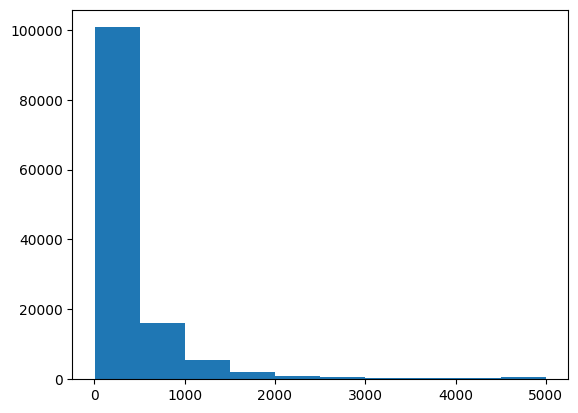

In [65]:
plt.hist([len(i) for i in train_data["comment_text"]])

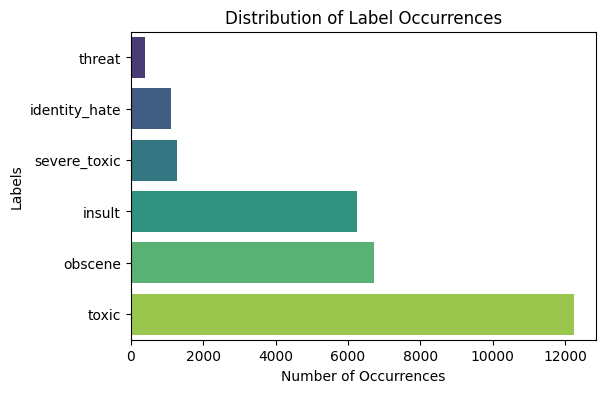

[  404  1111  1274  6263  6734 12238]


In [66]:
column_labels = train_data.columns.tolist()[2:]
label_counts = train_data[column_labels].sum().sort_values()

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')

plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
plt.show()
print(label_counts.values)

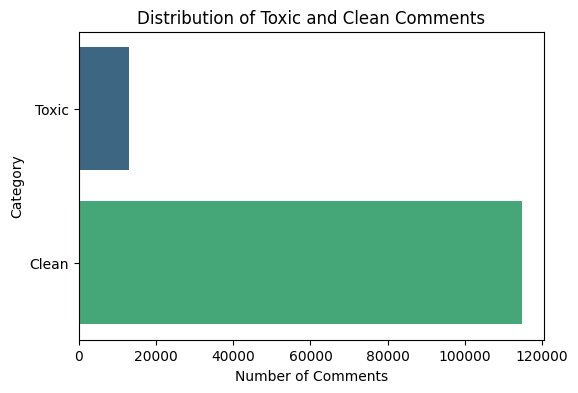

In [67]:
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(6, 4))

ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

ax.tick_params()

plt.show()

In [72]:
labels = ['threat', 'severe_toxic', 'identity_hate','obscene', 'insult']
sample = [32000,28000,28000,16000,16000]

balanced_train_data = train_clean

for i in range(len(labels)):
    column = labels[i]

    minority_comments = train_data[(train_data[column] == 1)]
    majority_comments = train_data[(train_data[column] == 0) & (train_data[column_labels].sum(axis=1) != 0)]
    
    minority_upsampled = resample(minority_comments,
                                   replace=True,
                                   n_samples=16000,
                                   random_state=42)
    
    balanced_train_data = pd.concat([balanced_train_data, majority_comments, minority_upsampled])

balanced_train_data = balanced_train_data.sample(frac=1, random_state=42)
len(balanced_train_data)

243794

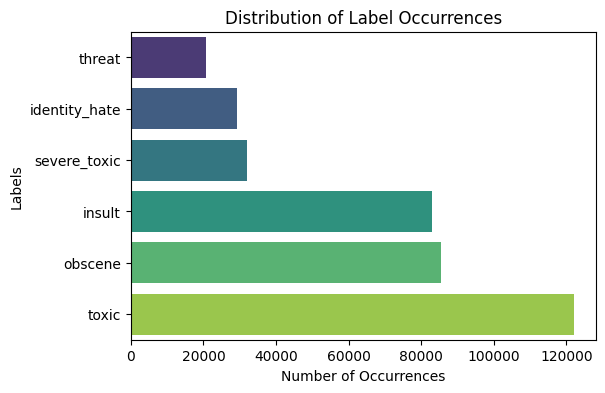

[ 20596  29345  32098  82996  85434 121971]


In [73]:
column_labels = balanced_train_data.columns.tolist()[2:]
label_counts = balanced_train_data[column_labels].sum().sort_values()

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')

plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
plt.show()
print(label_counts.values)

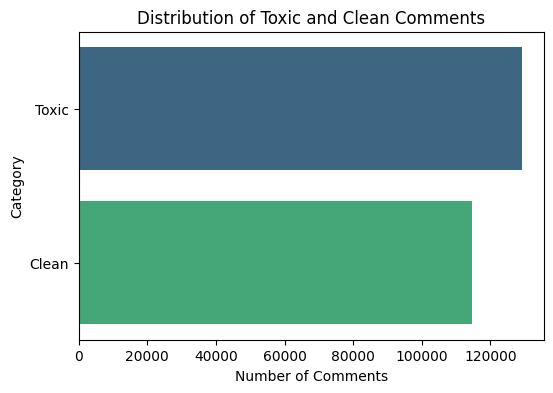

In [74]:
train_toxic = balanced_train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = balanced_train_data[train_data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(6, 4))

ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

ax.tick_params()

plt.show()

<Axes: title={'center': 'Correlation of Toxicity Criteria with Each Other'}>

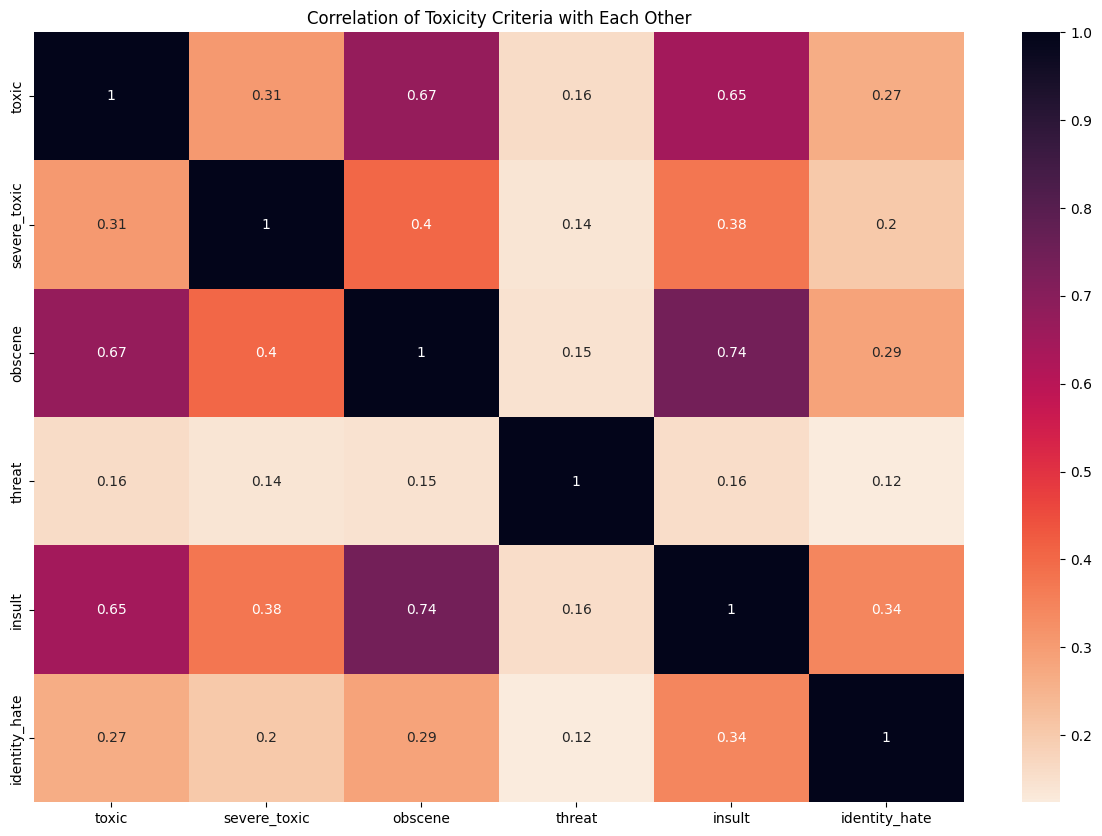

In [75]:
fig, ax = plt.subplots(figsize=(15, 10))

labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
plt.title('Correlation of Toxicity Criteria with Each Other')

sns.heatmap(train_data[labels_list].corr(),cmap='rocket_r', annot=True)

### Preprocessing

In [76]:
max_words = 10000  # Number of words in your vocabulary
max_seq_length = 150  # Maximum sequence length for padding
embedding_dim = 100

In [77]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(balanced_train_data['comment_text'])

In [78]:
train_sequences = tokenizer.texts_to_sequences(balanced_train_data['comment_text'])
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_seq_length)

test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_length)

In [79]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences_padded, balanced_train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(balanced_train_data))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(8)

### Model Creation (Bidirectional LSTM)

In [80]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'), 
    Dense(6, activation='sigmoid')
])

In [81]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [82]:
epochs = 3
stop_early = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
model.fit(train_dataset, epochs=epochs, callbacks = [stop_early])

Epoch 1/3
7619/7619 [==============================] - 151s 18ms/step - loss: 0.2846 - accuracy: 0.9558
Epoch 2/3
7619/7619 [==============================] - 104s 13ms/step - loss: 0.1952 - accuracy: 0.9689
Epoch 3/3
7619/7619 [==============================] - 102s 13ms/step - loss: 0.1531 - accuracy: 0.9565


In [83]:
model.save("LSTM-Model")

INFO:tensorflow:Assets written to: LSTM-Model/assets


INFO:tensorflow:Assets written to: LSTM-Model/assets


### Using the model to predict

In [84]:
model = tf.keras.models.load_model('LSTM-Model')

In [85]:
predictions = model.predict(test_sequences_padded)
rounded_predictions = np.round(predictions)

print(classification_report(test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], rounded_predictions))

998/998 [==============================] - 5s 5ms/step
              precision    recall  f1-score   support

           0       0.65      0.84      0.74      3056
           1       0.42      0.50      0.45       321
           2       0.79      0.83      0.81      1715
           3       0.28      0.47      0.35        74
           4       0.69      0.70      0.69      1614
           5       0.35      0.35      0.35       294

   micro avg       0.66      0.77      0.71      7074
   macro avg       0.53      0.62      0.57      7074
weighted avg       0.67      0.77      0.71      7074
 samples avg       0.07      0.07      0.07      7074



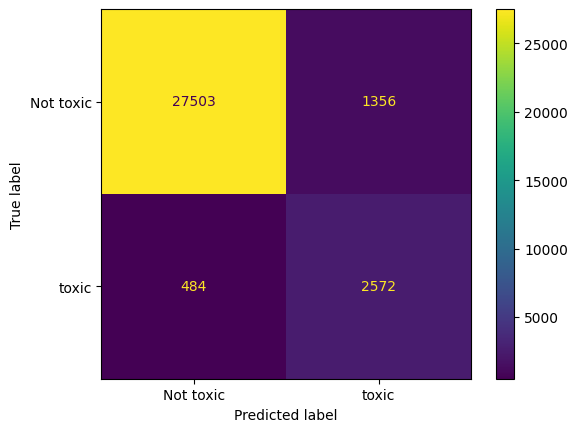

In [97]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

label = 'toxic'

conf_matrix = confusion_matrix(test_data[label], rounded_predictions[:,0])
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=[f"Not {label}",f"{label}"])
cm_display.plot()

In [105]:
def predict_toxicity(model, sentence):

    flag = True

    sentence = sentence.lower() 
    sentence_sequence = tokenizer.texts_to_sequences([sentence])
    sentence_sequence_padded = pad_sequences(sentence_sequence, maxlen=max_seq_length)

    predictions = model.predict(sentence_sequence_padded)
    predicted_labels = [True if prediction >= 0.5 else False for prediction in predictions[0]]

    for label, prediction in zip(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], predicted_labels):
        if(prediction):
            print(f"{label.capitalize()}")
            flag = False
    
    if(flag):
        print("Clean")

In [108]:
test_sentence = "I will kill you"

predict_toxicity(model, test_sentence)

1/1 [==============================] - 0s 19ms/step
Toxic
Threat


### BERT

In [ ]:
data = pd.read_csv("train.csv")
print(data.head())

In [ ]:
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()

In [ ]:
train_toxic = data[data[column_labels].sum(axis=1) > 0]
train_clean = data[data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

In [ ]:
train_clean_sampled = train_clean.sample(n=16225, random_state=42)
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)
dataframe = dataframe.sample(frac=1, random_state=42)

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
	dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)

In [ ]:
test_texts, val_texts, test_labels, val_labels = train_test_split(
	test_texts, test_labels, test_size=0.5, random_state=42)

In [ ]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
	input_ids = []
	attention_masks = []
	for comment in comments:
		encoded_dict = tokenizer.encode_plus(
			comment,
			add_special_tokens=False,
			max_length=max_length,
			pad_to_max_length=True,
			return_attention_mask=True,
			return_tensors='pt'
		)
		input_ids.append(encoded_dict['input_ids'])
		attention_masks.append(encoded_dict['attention_mask'])

	input_ids = torch.cat(input_ids, dim=0)
	attention_masks = torch.cat(attention_masks, dim=0)
	labels = torch.tensor(labels, dtype=torch.float32)

	return input_ids, attention_masks, labels

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=6)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
input_ids, attention_masks, labels = tokenize_and_encode(
	tokenizer,
	train_texts,
	train_labels.values
)
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
	tokenizer,
	test_texts,
	test_labels.values
)
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
	tokenizer,
	val_texts,
	val_labels.values
)

print('Training Comments :',train_texts.shape)
print('Input Ids		 :',input_ids.shape)
print('Attention Mask :',attention_masks.shape)
print('Labels		 :',labels.shape)

In [ ]:
batch_size = 16
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
def train_model(model, train_loader, optimizer, device, num_epochs):

	loss_line = []
	val_loss_line = []

	for epoch in range(num_epochs):

		model.train()
		total_loss = 0

		for batch in train_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			optimizer.zero_grad()

			outputs = model(
				input_ids, attention_mask=attention_mask, labels=labels)
			loss = outputs.loss
			total_loss += loss.item()

			loss.backward()
			optimizer.step()

		model.eval() 

		val_loss = 0
		with torch.no_grad():
			for batch in val_loader:
				input_ids, attention_mask, labels = [
					t.to(device) for t in batch]

				outputs = model(
					input_ids, attention_mask=attention_mask, labels=labels)
				loss = outputs.loss
				val_loss += loss.item()
		print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')
		loss_line += [total_loss/len(train_loader)]
		val_loss_line += [val_loss/len(val_loader)]
	
	plt.figure(figsize=(10, 6))
	plt.plot(loss_line, label='Loss')
	plt.plot(val_loss_line, label='Validation Loss')
	plt.title('Model Loss')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()
	plt.grid(True)
	plt.show()

train_model(model, train_loader, optimizer, device, num_epochs=10)

In [ ]:
def evaluate_model(model, test_loader, device):
	model.eval()

	true_labels = []
	predicted_probs = []

	with torch.no_grad():
		for batch in test_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			outputs = model(input_ids, attention_mask=attention_mask)
			predicted_probs_batch = torch.sigmoid(outputs.logits)
			predicted_probs.append(predicted_probs_batch.cpu().numpy())

			true_labels_batch = labels.cpu().numpy()
			true_labels.append(true_labels_batch)

	true_labels = np.concatenate(true_labels, axis=0)
	predicted_probs = np.concatenate(predicted_probs, axis=0)
	predicted_labels = (predicted_probs > 0.5).astype(int) 

	accuracy = accuracy_score(true_labels, predicted_labels)
	precision = precision_score(true_labels, predicted_labels, average='micro')
	recall = recall_score(true_labels, predicted_labels, average='micro')

	print(f'Accuracy: {accuracy:.4f}')
	print(f'Precision: {precision:.4f}')
	print(f'Recall: {recall:.4f}')

evaluate_model(model, test_loader, device)

In [ ]:
output_dir = "BERT-Model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

### Prediction using BERT

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = "BERT-Model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
	user_input = [input_text]

	user_encodings = tokenizer(
		user_input, truncation=True, padding=True, return_tensors="pt")

	user_dataset = TensorDataset(
		user_encodings['input_ids'], user_encodings['attention_mask'])

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

	model.eval()
	with torch.no_grad():
		for batch in user_loader:
			input_ids, attention_mask = [t.to(device) for t in batch]
			outputs = model(input_ids, attention_mask=attention_mask)
			logits = outputs.logits
			predictions = torch.sigmoid(logits)

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
	labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
	result = dict(zip(labels_list, predicted_labels[0]))
	return result

In [ ]:
predict_user_input(input_text="Your mother")